<a href="https://colab.research.google.com/github/Heng1222/Ohsumed_classification/blob/main/Model/task1_pytorch_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchinfo

,label,title
0,0,Haemophilus influenzae meningitis with prolong...
1,0,Augmentation mentoplasty using Mersilene mesh.
2,0,Multiple intracranial mucoceles associated wit...
3,0,Replacement of an aortic valve cusp after neon...
4,0,Mucosal intussusception to avoid ascending cho...


每個類別將統一採樣至: 427 筆
train data size:  (8838, 2)
test data size:  (983, 2)
Running Experiment with Base RoBERTa...


/tmp/ipython-input-3247456032.py:175: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  full_df = full_df.groupby('label').apply(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


base model：

Layer (type:depth-idx)                                       Param #
RobertaModel                                                 --
├─RobertaEmbeddings: 1-1                                     --
│    └─Embedding: 2-1                                        (38,603,520)
│    └─Embedding: 2-2                                        (394,752)
│    └─Embedding: 2-3                                        (768)
│    └─LayerNorm: 2-4                                        (1,536)
│    └─Dropout: 2-5                                          --
├─RobertaEncoder: 1-2                                        --
│    └─ModuleList: 2-6                                       --
│    │    └─RobertaLayer: 3-1                                (7,087,872)
│    │    └─RobertaLayer: 3-2                                (7,087,872)
│    │    └─RobertaLayer: 3-3                                (7,087,872)
│    │    └─RobertaLayer: 3-4                                (7,087,872)
│    │    └─RobertaLayer:

Epoch 1 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


Epoch 1 Training Loss: 3.1493 Validation Loss: 3.1287


Epoch 2 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


Epoch 2 Training Loss: 3.1296 Validation Loss: 3.1188


Epoch 3 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


Epoch 3 Training Loss: 3.1209 Validation Loss: 3.1103


Epoch 4 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 4 Training Loss: 3.1120 Validation Loss: 3.1021


Epoch 5 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 5 Training Loss: 3.1032 Validation Loss: 3.0938


Epoch 6 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 6 Training Loss: 3.0925 Validation Loss: 3.0857


Epoch 7 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 7 Training Loss: 3.0880 Validation Loss: 3.0781


Epoch 8 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 8 Training Loss: 3.0812 Validation Loss: 3.0707


Epoch 9 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 9 Training Loss: 3.0722 Validation Loss: 3.0631


Epoch 10 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 10 Training Loss: 3.0638 Validation Loss: 3.0558


Epoch 11 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 11 Training Loss: 3.0597 Validation Loss: 3.0486


Epoch 12 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 12 Training Loss: 3.0492 Validation Loss: 3.0416


Epoch 13 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 13 Training Loss: 3.0430 Validation Loss: 3.0341


Epoch 14 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.24it/s]


Epoch 14 Training Loss: 3.0368 Validation Loss: 3.0271


Epoch 15 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 15 Training Loss: 3.0319 Validation Loss: 3.0205


Epoch 16 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 16 Training Loss: 3.0236 Validation Loss: 3.0138


Epoch 17 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 17 Training Loss: 3.0172 Validation Loss: 3.0077


Epoch 18 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 18 Training Loss: 3.0114 Validation Loss: 3.0012


Epoch 19 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 19 Training Loss: 3.0075 Validation Loss: 2.9951


Epoch 20 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.26it/s]


Epoch 20 Training Loss: 3.0010 Validation Loss: 2.9889


Epoch 21 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 21 Training Loss: 2.9942 Validation Loss: 2.9830


Epoch 22 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 22 Training Loss: 2.9874 Validation Loss: 2.9768


Epoch 23 Validation: 100%|██████████| 28/28 [00:22<00:00,  1.25it/s]


Epoch 23 Training Loss: 2.9836 Validation Loss: 2.9708

--- Final Evaluation Report ---
              precision    recall  f1-score   support

           0       0.23      0.07      0.11        42
           1       0.31      0.77      0.44        43
           2       0.26      0.21      0.23        43
           3       0.20      0.44      0.28        43
           4       0.34      0.28      0.31        43
           5       1.00      0.07      0.13        43
           6       0.37      0.16      0.23        43
           7       0.45      0.21      0.29        43
           8       0.40      0.33      0.36        42
           9       0.35      0.21      0.26        42
          10       0.28      0.35      0.31        43
          11       0.00      0.00      0.00        43
          12       0.37      0.55      0.44        42
          13       0.16      0.21      0.18        43
          14       0.26      0.12      0.16        43
          15       0.62      0.12      0.20    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


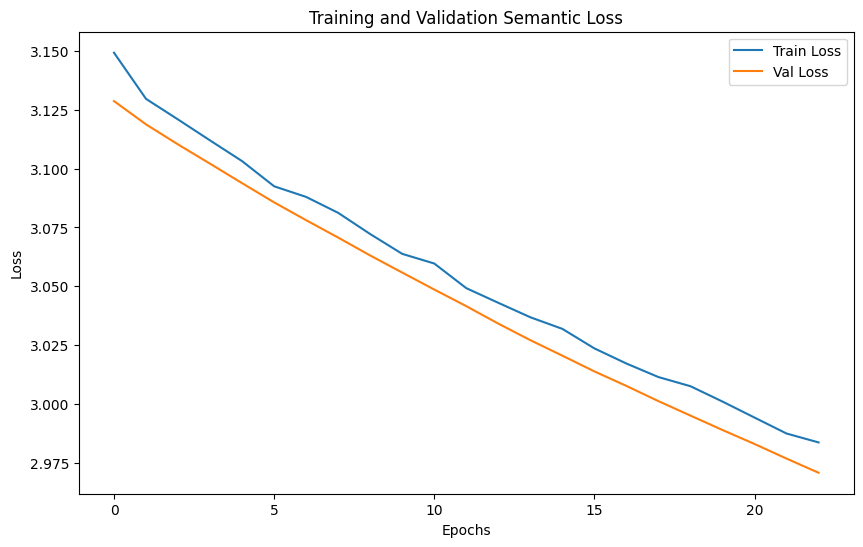

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from peft import PeftModel, PeftConfig
from torchinfo import summary

# 1. 定義分類模型
class RobertaClassifier(nn.Module):
  def __init__(self, model_path_or_name, num_labels=23, freeze_backbone=True, useLoRA = False):
    super(RobertaClassifier, self).__init__()
    # 載入 RoBERTa
    self.roberta = RobertaModel.from_pretrained(model_path_or_name)
    # LoRA 掛載
    if(useLoRA):
      # config = PeftConfig.from_pretrained("ybelkada/opt-350m-lora")
      LoRA_folder = "/content/roberta_semantic_lora"
      self.roberta = PeftModel.from_pretrained(self.roberta, LoRA_folder)
    # 凍結 RoBERTa 參數
    if freeze_backbone:
      for param in self.roberta.parameters():
        param.requires_grad = False

    # 定義分類層 (NN Head)
    # RoBERTa-base 的 hidden_size 是 768
    self.classifier = nn.Sequential(
      nn.Linear(768, num_labels)
    )

    # summary model
    print("base model：\n\n",summary(self.roberta))
    print("classifer NN Head：\n\n", summary(self.classifier))


  def forward(self, input_ids, attention_mask):
    outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
    # 使用 CLS Token 的向量 (也可以換成 Mean Pooling)
    cls_output = outputs.last_hidden_state[:, 0, :]
    logits = self.classifier(cls_output)
    return logits

# 2. 資料集處理
class TextDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len=512):
    self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_len, return_tensors="pt")
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return {
      'input_ids': self.encodings['input_ids'][idx],
      'attention_mask': self.encodings['attention_mask'][idx],
      'labels': self.labels[idx]
    }

# 3. 訓練與評估主程式
def run_experiment(model_name_or_path, train_df, test_df, num_epochs=23, useLoRA = False, folder_name = "default_model_name"):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # 初始化
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  model = RobertaClassifier(model_name_or_path, num_labels=23, useLoRA = useLoRA)

  model.to(device)

  # 測試集切割 9:1
  train_df, val_df = train_test_split(
    train_df,
    test_size=0.1,       # 抽取 10% 作為測試集
    random_state=42,
    stratify=train_df['label']
  )
  train_loader = DataLoader(TextDataset(train_df['title'].tolist(), train_df['label'].tolist(), tokenizer), batch_size=32, shuffle=True)
  val_loader =  DataLoader(TextDataset(val_df['title'].tolist(), val_df['label'].tolist(), tokenizer), batch_size=32)
  test_loader = DataLoader(TextDataset(test_df['title'].tolist(), test_df['label'].tolist(), tokenizer), batch_size=32)

  optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=2e-4)
  criterion = nn.CrossEntropyLoss()

  # 紀錄 Loss 用於輸出圖表
  train_losses, val_losses = [], []

  # 訓練迴圈
  for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
      optimizer.zero_grad()
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      logits = model(input_ids, attention_mask)
      loss = criterion(logits, labels)
      loss.backward()
      optimizer.step()
      total_loss += loss.item()

    # Validation
    model.eval()
    val_total_loss = 0
    with torch.no_grad():
      for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = model(input_ids, attention_mask)
        val_loss = criterion(logits, labels)
        val_total_loss += val_loss.item()

    avg_train = total_loss/len(train_loader)
    avg_val = val_total_loss/len(val_loader)
    train_losses.append(avg_train)
    val_losses.append(avg_val)
    print(f"Epoch {epoch+1} Training Loss: {avg_train:.4f} Validation Loss: {avg_val:.4f}")

  # test
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for batch in test_loader:
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      logits = model(input_ids, attention_mask)
      preds = torch.argmax(logits, dim=1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())

  # 詳細報表
  print("\n--- Final Evaluation Report ---")
  print(classification_report(all_labels, all_preds))
  # Loss 趨勢圖
  plt.figure(figsize=(10, 6))
  plt.plot(train_losses, label='Train Loss')
  plt.plot(val_losses, label='Val Loss')
  plt.title('Training and Validation Semantic Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  # # 儲存模型
  # model.save_pretrained(folder_name)
  # print(f"model saved to '{folder_name}'.")
  return all_labels, all_preds

# 執行範例
if __name__ == "__main__":
  # 資料讀取
  url = 'https://github.com/Heng1222/Ohsumed_classification/blob/main/classification_data/ohsumed_dataset.csv?raw=true'
  full_df = pd.read_csv(url)
  columns = ['label', 'title']
  full_df = full_df[columns]
  # 將分類標籤從字串轉換為數字
  unique_labels = full_df['label'].unique()
  label_to_id = {label: i for i, label in enumerate(sorted(unique_labels))}
  # 將 'label' 欄位轉換為數字
  full_df['label'] = full_df['label'].map(label_to_id)
  display(full_df.head())
  # 找出最少樣本的類別有多少筆
  min_sample_size = full_df['label'].value_counts().min()
  print(f"每個類別將統一採樣至: {min_sample_size} 筆")

  # 每個類別隨機抽取相同筆數
  full_df = full_df.groupby('label').apply(
      lambda x: x.sample(n=min_sample_size, random_state=42)
  ).reset_index(drop=True)
  # 分層抽樣
  # full_df = full_df.groupby('label', group_keys=False).apply(
  #   lambda x: x.sample(frac=0.1, random_state=42)
  # )
  train_df, test_df = train_test_split(
    full_df,
    test_size=0.1,       # 抽取 10% 作為測試集
    random_state=42,
    stratify=full_df['label']
  )
  print("train data size: ", train_df.shape)
  print("test data size: ", test_df.shape)

  # 實驗 1: 使用 原版RoBERTa
  print("Running Experiment with Base RoBERTa...")
  run_experiment('roberta-base', train_df, test_df, folder_name = "RoBERTa_based")

  # 實驗 2: 使用 MLM
  # print("Running Experiment with Custom RoBERTa...")
  # run_experiment('./my_mlm_roberta_path', train_df, test_df, folder_name = "RoBERTa_MLM")

  # 實驗 3: 使用 LoRA
  # print("Running Experiment with RoBERTa + LoRA...")
  # run_experiment('roberta-base', train_df, test_df, useLoRA = True, folder_name = "RoBERTa_LoRA")
